In [1]:
import dask
from dask.distributed import Client
import dask_jobqueue
import discretize
from discretize.utils import mkvc
# import deepdish as dd
import h5py
import json
import matplotlib.pyplot as plt
from matplotlib import cm as cmap
from matplotlib.colors import LogNorm, Normalize
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import xarray as xr
import zarr

import casingSimulations as casing_sim
from SimPEG import maps
from SimPEG.electromagnetics import time_domain as tdem
from pymatsolver import Pardiso

np.random.seed(29)

In [2]:
directory = "test"

if not os.path.isdir(directory):
    os.makedirs(directory, exist_ok=True)

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
nsamples = 2

In [5]:
# set bounds for the distributions of 
sigma_background_bounds = np.r_[1e-4, 1]
sigma_casing_bounds = np.r_[1e4, 1e7]

d_casing_bounds = np.r_[5e-2, 30e-2]
t_casing_bounds = np.r_[0.5e-2, 2e-2]
l_casing_bounds = np.r_[20, 4e3]

In [6]:
# constants
sigma_air = 1e-4
sigma_inside = 1  # fluid inside the casing
mur_casing = 1  # permeability is the same as free space

src_a = np.r_[0., 0., 0.]  # the radius will be updated to connect to the casing
src_b = np.r_[1000., 0, 0]

csz = 2.5  # cell-size in the z-direction
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [7]:
# areas to compare data

z_compare = np.linspace(-100, 0, 128)

In [8]:
def generate_random_variables(bounds, n_samples, sig_digs=None):
    min_value = bounds.min()
    max_value = bounds.max()
    v = np.random.rand(n_samples)
    v = min_value + (v*(max_value - min_value))
    if sig_digs is not None:
        v = np.round((v*10**(sig_digs)))/10**(sig_digs)
    return v

In [9]:
log10_sigma_background_dist = generate_random_variables(np.log10(sigma_background_bounds), nsamples, 2)
log10_sigma_casing_dist = generate_random_variables(np.log10(sigma_casing_bounds), nsamples, 2)

d_casing_dist = generate_random_variables(d_casing_bounds, nsamples, 2) 
t_casing_dist = generate_random_variables(t_casing_bounds, nsamples, 2) 
l_casing_dist = np.r_[1000, 1000]  #generate_random_variables(l_casing_bounds/csz, nsamples, 0) * csz # generate by ncells

parameters = {
    "log10_sigma_background":log10_sigma_background_dist,
    "log10_sigma_casing":log10_sigma_casing_dist,
    "d_casing":d_casing_dist,
    "t_casing":t_casing_dist,
    "l_casing":l_casing_dist,
}

In [10]:
df = pd.DataFrame(parameters)
df

,log10_sigma_background,log10_sigma_casing,d_casing,t_casing,l_casing
0,-0.54,4.22,0.16,0.02,1000
1,-2.86,6.29,0.19,0.02,1000


In [11]:
df.to_hdf(f"{directory}/trial_data.h5", 'data') #for key in df.keys()

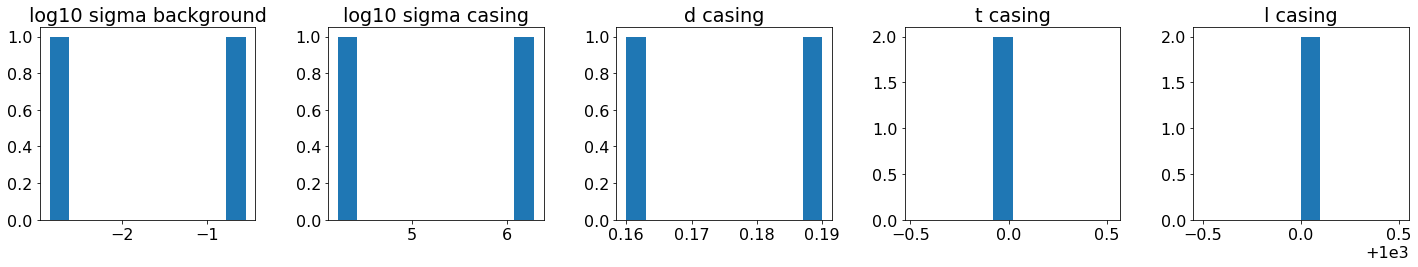

In [12]:
fig, ax = plt.subplots(1,5, figsize=(20, 4))

for i, key in enumerate(parameters.keys()):
    ax[i].hist(df[key])
    ax[i].set_title(f"{key}".replace("_", " "))

plt.tight_layout()

In [13]:
time_steps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 15)
]

In [14]:
df2 = pd.read_hdf(f"{directory}/trial_data.h5", 'data', start=1, stop=2)

In [15]:
df2["log10_sigma_background"]

1   -2.86
Name: log10_sigma_background, dtype: float64

In [16]:
i = 0

trial_directory = f"{directory}/trial_{i}/"
if not os.path.isdir(trial_directory):
    os.makedirs(trial_directory, exist_ok=True)

cd = parameters["d_casing"][i]
ct = parameters["t_casing"][i]
cl = parameters["l_casing"][i]

sc = 10**(parameters["log10_sigma_casing"][i])
sb = 10**(parameters["log10_sigma_background"][i])



In [17]:
model = casing_sim.model.CasingInHalfspace(
    directory=trial_directory,
    casing_d = cd - ct,  # I use diameter to the center of the casing wall
    casing_l = cl,
    casing_t = ct, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sc,
    sigma_back = sb,
    sigma_inside = sb,
    src_a = src_a,
    src_b = src_b,
    timeSteps = time_steps
)
model.filename = "casing.json"

np.sum(model.timeSteps)

0.18422000000000002

In [18]:
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(f"The approximate conductivity of the solid we use is {sigmaA:1.1e}")

model_approx_casing = model.copy()
model_approx_casing.casing_t = cd / 2.
model_approx_casing.casing_d = cd - model_approx_casing.casing_t
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

The approximate conductivity of the solid we use is 7.3e+03


In [19]:
def generate_mesh(model):
    csx1 = model.casing_t/4
    csx2 = 100
    csz = 2.5
    
    # esure padding goes sufficiently far in the x direction
    pad_to = 1e4
    npad_x = 0
    npad_z = 0
    padding_x = cl
    padding_z = cl
    pfx2 = 1.5
    pfz = 1.5
#     csx2 = 10
    
    while padding_x < pad_to:
        npad_x += 1
        padding_x = cl + np.sum((csx2 * (np.ones(npad_x)*pfx2)**np.arange(1, npad_x+1)))
    
    while padding_z < pad_to:
        npad_z += 1
        padding_z = cl + np.sum((csz * (np.ones(npad_z)*pfz)**np.arange(1, npad_z+1)))
    
    meshGen = casing_sim.mesh.CasingMeshGenerator(
        modelParameters = model, 
        csx1 = csx1,
        csx2 = csx2,
        domain_x = cl, 
        hy = hy,
        npadx = npad_x, 
        npadz = npad_z, 
        csz = csz,
        _ncx1 = np.ceil(cd / csx1)
    )
    mesh = meshGen.mesh
    return meshGen, mesh

In [20]:
meshGen, mesh = generate_mesh(model)
# meshGen_approx, mesh_approx = meshGen, mesh
meshGen_approx, mesh_approx = generate_mesh(model_approx_casing)

742.8652886064586


/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/matplotlib/projections/polar.py:55: RuntimeWarning: invalid value encountered in greater_equal
  r = np.where(r >= 0, r, np.nan)


470976 315768


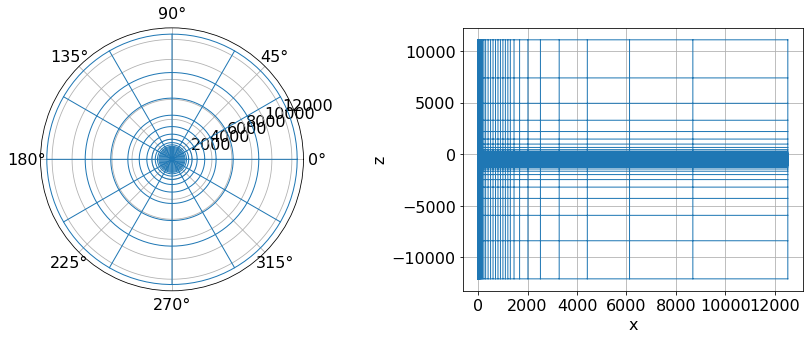

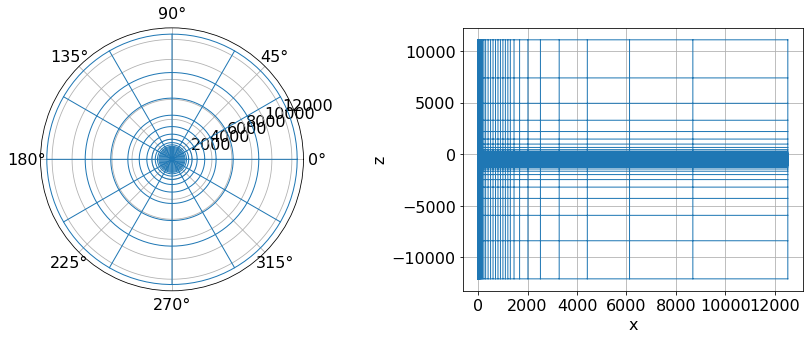

In [21]:
print(model.diffusion_distance(t=0.1))

ax = mesh.plotGrid()

# ax[1].set_xlim([0, 1100])

ax2 = mesh_approx.plotGrid()

print(mesh.nC, mesh_approx.nC)

In [22]:
def get_source(model, mesh, meshGen):
    src_theta = np.pi/2. + mesh.hy[0]/2.
    model.src_a[1] = src_theta
    model.src_b[1] = src_theta
    
    src_top = casing_sim.sources.TopCasingSrc(
        modelParameters=model, 
        meshGenerator=meshGen,
        src_a=model.src_a,
        src_b=model.src_b,
        physics="TDEM",
        filename="top_casing",
    )

    source_list = src_top.srcList
    return source_list

In [23]:
source_list = get_source(model, mesh, meshGen)
source_list_approx = get_source(model_approx_casing, mesh_approx, meshGen_approx)

In [24]:
physprops = casing_sim.model.PhysicalProperties(modelParameters=model, meshGenerator=meshGen)
physprops_approx = casing_sim.model.PhysicalProperties(modelParameters=model_approx_casing, meshGenerator=meshGen_approx)

In [25]:
model.casing_b, model_approx_casing.casing_b

(0.08, 0.08)

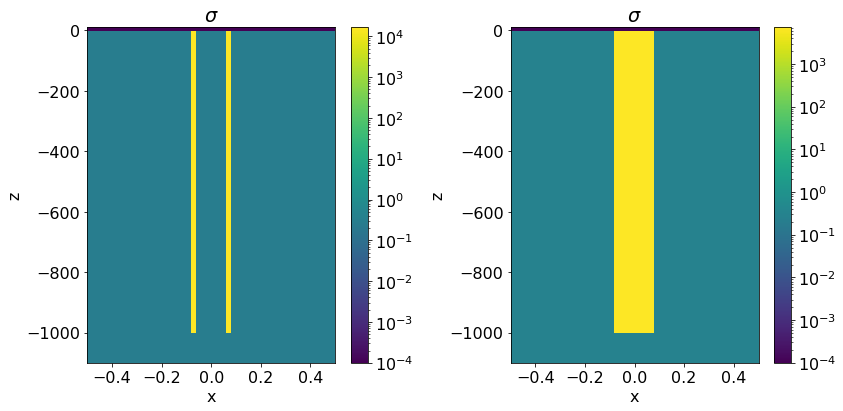

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

xlim = 0.5 * np.r_[-1, 1]
zlim = np.r_[-model.casing_l*1.1, 10]

physprops.plot_sigma(ax=ax[0], pcolorOpts={'norm':LogNorm()})
physprops_approx.plot_sigma(ax=ax[1], pcolorOpts={'norm':LogNorm()})

for a in ax:
    a.set_xlim(xlim)
    a.set_ylim(zlim)

plt.tight_layout()

In [27]:
np.save(f"{trial_directory}casing.npy", model.sigma(mesh))
np.save(f"{trial_directory}approx_casing.npy", model_approx_casing.sigma(mesh_approx))

In [28]:
survey = tdem.Survey(source_list)
survey_approx = tdem.Survey(source_list_approx)

In [29]:
sim = tdem.Problem3D_j(mesh=mesh, survey=survey, solver=Pardiso, time_steps=time_steps)
sim_approx = tdem.Problem3D_j(mesh=mesh_approx, survey=survey_approx, solver=Pardiso, time_steps=time_steps)

with open(f"{trial_directory}simulation.json", 'w') as outfile:
    json.dump(sim.serialize(), outfile)

with open(f"{trial_directory}simulation_approx.json", 'w') as outfile:
    json.dump(sim_approx.serialize(), outfile)

In [30]:
def compute_fields(model, simulation, trial_directory):
    import deepdish as dd
    import discretize
    import casingSimulations as casing_sim
    from SimPEG.electromagnetics import time_domain as tdem
    from SimPEG import maps
    from pymatsolver import Pardiso
    
#     simulation_params = dd.io.load(f"{trial_directory}simulation.h5")
#     print(f"{trial_directory}simulation.json")
    with open(f"{trial_directory}{simulation}.json") as f:
        simulation_params = json.load(f)
    sim = tdem.Problem3D_j.deserialize(simulation_params, trusted=True)
    mesh = sim.mesh
    sim.solver = Pardiso
    sim.sigmaMap=maps.IdentityMap(mesh)
    sim.verbose=True
    
    m = np.load(f"{trial_directory}{model}.npy")
    fields = sim.fields(m)
    f = fields[:, '{}Solution'.format(sim._fieldType), :]
 
    filename = f"{model}_fields.npy"
    tosave = os.path.sep.join([trial_directory, filename]) 
    print(f"saving {tosave}")
    np.save(tosave, f)
    
    return tosave

In [34]:
cluster = dask_jobqueue.SLURMCluster(
    cores=nsamples,
    processes=nsamples*2, memory=f'{120*nsamples}GB', 
    job_cpu=1,
    project="m3384",
    job_extra = ['--constraint=haswell', '--qos=debug',], 
    death_timeout=360,
)

print(cluster.job_script())



#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -A m3384
#SBATCH -n 1
#SBATCH --cpus-per-task=1
#SBATCH --mem=224G
#SBATCH -t 00:30:00
#SBATCH --constraint=haswell
#SBATCH --qos=debug

JOB_ID=${SLURM_JOB_ID%;*}

/global/homes/l/lheagy/.conda/envs/simpeg37/bin/python -m distributed.cli.dask_worker tcp://128.55.224.49:38515 --nthreads 0 --nprocs 4 --memory-limit 60.00GB --name name --nanny --death-timeout 360



/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [35]:
client = Client(cluster)
client

# client = Client(threads_per_worker=1, n_workers=2)
# client

Client Scheduler: tcp://128.55.224.49:38515 Dashboard: http://128.55.224.49:35001/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [48]:
f = {}
for m, sim in zip(["casing", "approx_casing"], ["simulation", "simulation_approx"]):
#     f[m] = compute_fields(m, trial_directory)
    f[m] = dask.delayed(compute_fields)(m, sim, trial_directory)

In [49]:
cluster.scale(1)

In [ ]:
fields_files = dask.compute(f)[0]

In [113]:
ndata = 32
ntimes = 128
xsample = np.linspace(25, 1000, ndata)
zsample = np.linspace(-cl, 0, ndata)
xz_grid = discretize.utils.ndgrid(xsample, np.r_[0], zsample)
tsample = np.logspace(-6, -2, 128)

In [114]:
currents = {}
for m in ["casing", "approx_casing"]:
    currents[m] = np.load(f"{trial_directory}{m}_fields.npy")

In [115]:
def get_matching_indices(grid="x"):
    vnF = getattr(mesh, f"vnF{grid}")
    vnF_approx = getattr(mesh_approx, f"vnF{grid}")
    
    x0 = np.ones(vnF[0], dtype=bool)
    x0[:vnF[0] - vnF_approx[0]] = False
    return np.kron(np.ones(vnF[2], dtype=bool), np.kron(np.ones(vnF[1], dtype=bool), x0))


In [116]:
indsFx = get_matching_indices("x")
indsFy = get_matching_indices("y")
indsFz = get_matching_indices("z")

inds = np.hstack([indsFx, indsFy, indsFz])

In [117]:
# compute jd
jd = currents["casing"][inds] - currents["approx_casing"]

In [118]:
jdx = mkvc(jd[:mesh_approx.vnF[0], :]).reshape(tuple(mesh_approx.vnFx)+(sim_approx.nT+1,), order="F")
jdz = mkvc(jd[np.sum(mesh_approx.vnF[:2]):, :]).reshape(tuple(mesh_approx.vnFz)+(sim_approx.nT+1,), order="F")

# take mean in theta-dimension jdx.mean(1)
jdx = jdx.mean(1)
jdz = jdz.mean(1)

jdxz = np.hstack([mkvc(jdx), mkvc(jdz)])

In [119]:
hx1a = discretize.utils.meshTensor([(meshGen.csx1, meshGen.ncx1)])

# pad to second uniform region
hx1b = discretize.utils.meshTensor([(meshGen.csx1, meshGen.npadx1, meshGen.pfx1)])

# scale padding so it matches cell size properly
dx1 = np.sum(hx1a)+np.sum(hx1b)
dx1 = 3 #np.floor(dx1/meshGen.csx2)
hx1b *= (dx1*meshGen.csx2 - np.sum(hx1a))/np.sum(hx1b)

# second uniform chunk of mesh
ncx2 = np.ceil((meshGen.domain_x - dx1)/meshGen.csx2)
hx2a = discretize.utils.meshTensor([(meshGen.csx2, ncx2)])

# pad to infinity
hx2b = discretize.utils.meshTensor([(meshGen.csx2, meshGen.npadx, meshGen.pfx2)])

hx = np.hstack([hx1a, hx1b, hx2a, hx2b])

In [120]:
hx1a_a = discretize.utils.meshTensor([(meshGen_approx.csx1, meshGen_approx.ncx1)])

# pad to second uniform region
hx1b_a = discretize.utils.meshTensor([(meshGen_approx.csx1, meshGen_approx.npadx1, meshGen_approx.pfx1)])

# scale padding so it matches cell size properly
dx1_a = np.sum(hx1a_a)+np.sum(hx1b_a)
dx1_a = 3 #np.floor(dx1_a/meshGen_approx.csx2)
hx1b_a *= (dx1_a*meshGen_approx.csx2 - np.sum(hx1a_a))/np.sum(hx1b_a)

# second uniform chunk of mesh
ncx2_a = np.ceil((meshGen_approx.domain_x - dx1_a)/meshGen_approx.csx2)
hx2a_a = discretize.utils.meshTensor([(meshGen_approx.csx2, ncx2_a)])

# pad to infinity
hx2b_a = discretize.utils.meshTensor([(meshGen_approx.csx2, meshGen_approx.npadx, meshGen_approx.pfx2)])

hx2 = np.hstack([hx1a_a, hx1b_a, hx2a_a, hx2b_a])

In [121]:
x1 = np.cumsum(np.hstack([np.r_[0], hx]))

In [122]:
x2 = np.cumsum(np.hstack([np.r_[0], hx2]))

In [123]:
mesh.vectorNx[mesh.vectorNx > 25]

array([   30.        ,    40.        ,    50.        ,    60.        ,
          70.        ,    80.        ,    90.        ,   100.        ,
         110.        ,   120.        ,   130.        ,   145.        ,
         167.5       ,   201.25      ,   251.875     ,   327.8125    ,
         441.71875   ,   612.578125  ,   868.8671875 ,  1253.30078125,
        1829.95117188,  2694.92675781,  3992.39013672,  5938.58520508,
        8857.87780762, 13236.81671143])

In [1]:
mesh_approx.vectorNx[mesh_approx.vectorNx > 25]

NameError: name 'mesh_approx' is not defined

0.0 ms


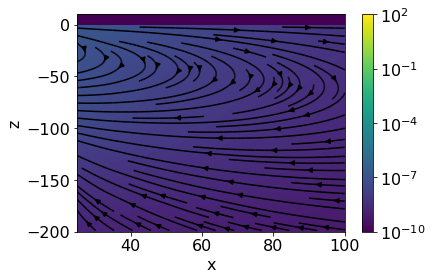

In [147]:
tind = 0
print(f"{sim_approx.timeMesh.vectorNx[tind]*1e3} ms")
plt.colorbar(mesh2d.plotImage(
#     mesh2d.aveF2CCV * currents["approx_casing"],
    mesh2d.aveF2CCV * np.hstack([mkvc(jdx[:, :, tind]), mkvc(jdz[:, :, tind])]), 
    view="vec",
    vType="CCv", range_x=np.r_[25, 100], range_y=[-200, 10], pcolorOpts={"norm": LogNorm()},
    clim = np.r_[1e-10, 1e2],
    stream_threshold=1e-10,
)[0])

In [111]:
# build projection matrices for data 
mesh2d = discretize.CylMesh([mesh_approx.hx, 1, mesh_approx.hz], x0=mesh_approx.x0)
Px = mesh2d.getInterpolationMat(xz_grid, 'Fx')
Pz = mesh2d.getInterpolationMat(xz_grid, 'Fz')
Pt = sim_approx.time_mesh.getInterpolationMat(tsample, 'N')

Pxt = sp.kron(Pt, Px)
Pzt = sp.kron(Pt, Pz)
P = sp.vstack([Pxt, Pzt])

jdata = P * jdxz
np.save(f"{trial_directory}j_difference.npy", jdata)

In [73]:
a = np.r_[0, 0.5, 1.]
a.astype(bool)

array([False,  True,  True])

In [76]:
# compute current inside casing
ind_casing_Fz = (mesh_approx.aveFz2CC.T * model_approx_casing.ind_casing(mesh_approx)).astype(bool)

I = discretize.utils.sdiag(mesh_approx.area) * currents["approx_casing"]
Iz = I[mesh_approx.vnF[:2].sum():, :]
Iz[~ind_casing_Fz, :] = 0


In [77]:
Iz = Iz.reshape(tuple(mesh_approx.vnFz) + (sim_approx.nT+1,), order="F")

In [78]:
Iz_casing = (Iz.sum(0)).sum(0)

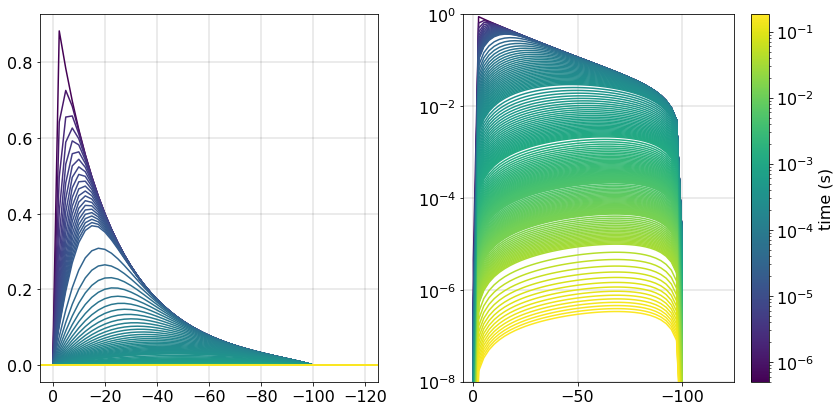

In [80]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cm = plt.get_cmap('viridis')
c_norm = LogNorm(vmin=sim_approx.timeMesh.vectorCCx[0], vmax=sim_approx.timeMesh.vectorNx[-1])
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for i in range(sim_approx.nT):
    ax[0].plot(
        mesh_approx.vectorNz, -Iz_casing[:, i], 
        color=scalar_map.to_rgba(sim_approx.timeMesh.vectorNx[i]+1e-7)
    )
    ax[1].semilogy(
        mesh_approx.vectorNz, np.abs(-Iz_casing[:, i]), 
        color=scalar_map.to_rgba(sim_approx.timeMesh.vectorNx[i]+1e-7)
    )

for a in ax:
    a.set_xlim([5., -1.25*model.casing_l])
    a.grid(which="both", color="k", lw=0.4, alpha=0.4)

ax[1].set_ylim([1e-8, 1])

cb = plt.colorbar(scalar_map)
cb.set_label("time (s)")
plt.tight_layout()

/global/homes/l/lheagy/.conda/envs/simpeg37/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  # Remove the CWD from sys.path while we load stuff.


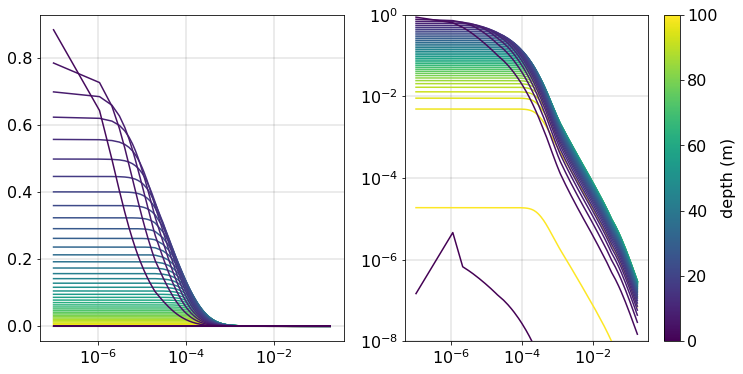

In [81]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

cm = plt.get_cmap('viridis')
c_norm = Normalize(vmin=0, vmax=model.casing_l)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

for i in range(mesh_approx.vnFz[2]):
    ax[0].semilogx(sim_approx.timeMesh.vectorNx+1e-7, -Iz_casing[i, :], color=scalar_map.to_rgba(-mesh_approx.vectorNz[i]))
    ax[1].loglog(sim_approx.timeMesh.vectorNx+1e-7, np.abs(-Iz_casing[i, :]), color=scalar_map.to_rgba(-mesh_approx.vectorNz[i]))

for a in ax:
#     a.set_xlim([5., -1.25*model.casing_l])
    a.grid(which="both", color="k", lw=0.4, alpha=0.4)

ax[1].set_ylim([1e-8, 1])

cb=plt.colorbar(scalar_map)
cb.set_label("depth (m)")


In [82]:
n_z_currents = 128
z_sample = np.linspace(-model_approx_casing.casing_l, 0, n_z_currents)
Pz_casing_currents = discretize.TensorMesh([mesh_approx.hz], [mesh_approx.x0[2]]).getInterpolationMat(
    z_sample, 'N'
)

In [83]:
P_casing_currents = sp.kron(Pt, Pz_casing_currents)
I_casing_data = -1*P_casing_currents*discretize.utils.mkvc(Iz_casing)
np.save(f"{trial_directory}casing_currents.npy", I_casing_data)

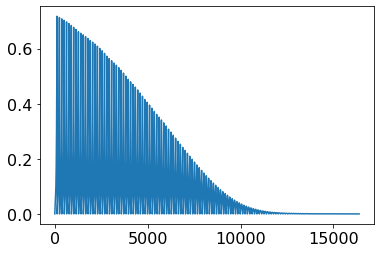

In [84]:
plt.plot(I_casing_data)